In [57]:
from glob import glob
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Folder extracted replays

In [8]:
datasetfolder = "i:/StarCraft_BO/replayActionList/*"

In [9]:
datasetfiles = glob(datasetfolder)

In [11]:
datasetfiles[0]

'i:/StarCraft_BO/replayActionList\\398305.csv'

### Explore files

In [12]:
with open(datasetfiles[0], 'r') as file:
    data = file.readlines()

In [15]:
data[:10]

['Sc2gears 14.3.3 Command Line Interface\n',
 '-------print-action-list\n',
 '20\tSpaceCore\tMove screen x=62.00,y=21.76; distance=34.00; pitch=21.80-¦; yaw=-90.00-¦\n',
 '44\tHybriD\tMove screen x=24.50,y=62.26; distance=34.00; pitch=21.80-¦; yaw=-90.00-¦\n',
 '56\tHybriD\tSelect Drone x6 (10248,1024c,10250,10254,10258,1025c)\n',
 '64\tSpaceCore\tSelect Larva x3 (10270,10274,10278)\n',
 '64\tSpaceCore\tTrain Drone\n',
 '88\tSpaceCore\tSelect Egg (10270), Deselect 1 unit\n',
 '100\tSpaceCore\tSelect Drone x6 (10228,1022c,10230,10234,10238,1023c), Deselect all\n',
 '100\tHybriD\tRight click; target: Mineral Field (100d0); target: x=21.00,y=65.50\n']

In [16]:
data[-10:]

['44736\tHybriD\tHotkey Select 2\n',
 '44748\tHybriD\tMove screen x=58.76,y=24.97\n',
 '44760\tHybriD\tDeselect 1 unit\n',
 '44768\tHybriD\tDeselect 16 units\n',
 '44768\tHybriD\tHotkey Select 4\n',
 '44792\tHybriD\tSelect Roach x7 (203dc,30404,40464,20468,1048c,104a8,104ac), Zergling x10 (50234,302a8,b02b0,902dc,70310,d03f8,50420,204c8,304d4,404dc), Deselect all\n',
 '44792\tHybriD\tHotkey Select 2\n',
 '44804\tHybriD\tHotkey Select 4\n',
 '44816\tHybriD\tMove screen x=27.50,y=61.76\n',
 '44824\tSpaceCore\tLeave game\n']

First column is the time in game frames. One frame is 11.278 ms.  
Second column is the player name.  
Third column is the action and parameters.  

### Split players

In [84]:
def extract_players_names(filepath):
    with open(filepath, 'r') as file:
        player_names = list(set([x.split()[1] for x in file.readlines()[2:]]))
    return player_names

In [89]:
def split_players(filepath):
    player_names = extract_players_names(filepath)
    with open(filepath, 'r') as file:        
        player1 = []
        player2 = []
        for line in file.readlines()[2:]:
            if line.split()[1] == player_names[0]:
                player1.append(line)
            elif line.split()[1] == player_names[1]:
                player2.append(line)
    return player1, player2

In [240]:
p1, p2 = split_players(datasetfiles[7])

In [279]:
for line in p1[:3]:
    print(line.split('\t')[::2])

['32', 'Move screen x=135.50,y=101.26; distance=34.00; pitch=21.80-¦; yaw=-90.00-¦\n']
['32', 'Select Hatchery (10240)\n']
['100', 'Select Drone x6 (10244,10248,1024c,10250,10254,10258), Deselect all\n']


### Extract Move Screen

In [282]:
def extract_positions(player_moves):
    frames = []
    x_position = []
    y_position = []
    for line in player_moves:
        t, _, a = line.split('\t')
        if re.match(r'Move screen', a):
            m= re.search(r'x=(\d+\.\d+),y=(\d+\.\d+)', a)
            x = m.group(1)
            y = m.group(2)
#             y = re.search(r'', a).group(1)
            frames.append(int(t))
            x_position.append(float(x))
            y_position.append(float(y))
    return pd.DataFrame({'frames': frames, 'x':x_position, 'y':y_position})

In [283]:
moveScreen_p1 = extract_positions(p1)
moveScreen_p2 = extract_positions(p2)

In [284]:
moveScreen_p1['player'] = 'p1'
moveScreen_p2['player'] = 'p2'

In [285]:
df = pd.concat([moveScreen_p1, moveScreen_p2])

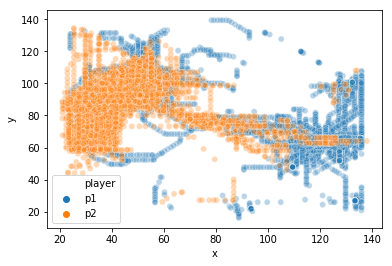

In [286]:
sns.scatterplot(x='x',y='y', hue='player', alpha=0.3, data=df)
plt.show()

In [246]:
df1 = df[df.player=='p1'].copy()
df1['count'] = 1
df1.x = df1.x.astype(int)
df1.y = df1.y.astype(int)

In [247]:
df2 = df[df.player=='p2'].copy()
df2['count'] = 1
df2.x = df2.x.astype(int)
df2.y = df2.y.astype(int)

In [248]:
pt = pd.pivot_table(df1, values='count', index='y', columns='x', aggfunc='sum')

In [249]:
pt2 = pd.pivot_table(df2, values='count', index='y', columns='x', aggfunc='sum')

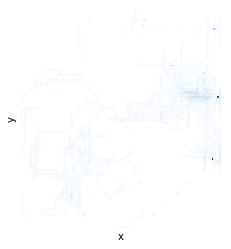

In [250]:
sns.heatmap(pt, square=True, cmap="Blues", yticklabels=False, xticklabels=False, cbar=False)
plt.show()

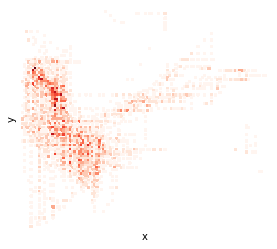

In [251]:
sns.heatmap(pt2, square=True, cmap="Reds", yticklabels=False, xticklabels=False, cbar=False)
plt.show()

### Extract training units

In [252]:
actions = [y.split()[:2] for y in [x.split('\t')[2] for x in p2]]

In [257]:
actions[:3]

[['Move', 'screen'], ['Select', 'SCV'], ['Right', 'click;']]

In [258]:
action_types = set([x[0] for x in actions if len(x)>1])

In [259]:
action_types

{'Attack;',
 'Build',
 'Calldown',
 'Deselect',
 'Hotkey',
 'Land',
 'Leave',
 'Lift',
 'Lower',
 'Move',
 'Raiser',
 'Research',
 'Right',
 'Scanner',
 'Select',
 'Selection',
 'Set',
 'Siege',
 'Stimpack',
 'Tank',
 'Train',
 'Upgrade',
 '[Failed]',
 '[MinimapClick]',
 '[Queued]',
 '[WireframeClick]'}

In [260]:
action_target = set([x[1] for x in actions if len(x) > 1])

In [261]:
action_target

{'(Command',
 '(Factory);',
 '(Mixed',
 '(Orbital',
 '1',
 '10',
 '12',
 '2',
 '25',
 '3',
 '4',
 '45',
 '5',
 '6',
 '8',
 '9',
 'Armory',
 'Armory;',
 'Assign',
 'Attack;',
 'Barracks',
 'Barracks;',
 'Build',
 'Calldown',
 'Command',
 'Destructible',
 'Engineering',
 'Extra',
 'Factory',
 'Factory;',
 'Hellion',
 'MULE',
 'Marauder',
 'Marine',
 'Mineral',
 'Missile',
 'Mode',
 'Off',
 'Orbital',
 'Planetary',
 'Rally',
 'Reactor',
 'Refinery;',
 'Right',
 'SCV',
 'Select',
 'Siege',
 'Supply',
 'Sweep',
 'Tech',
 'Terran',
 'Thor',
 'Upgrade',
 'Vespene',
 '[MinimapClick]',
 '[WireframeCancel]',
 'all',
 'auto-update',
 'click;',
 'game',
 'screen',
 'target:',
 'to'}

In [268]:
p2_training = []
for line in p2:
    cols = line.split('\t')
    action = cols[2].split()[:2]
    if len(action)>1 and action[0] == 'Train':
        p2_training.append((cols[0], action[1]))

In [269]:
p2_training

[('256', 'SCV'),
 ('1248', 'SCV'),
 ('2248', 'SCV'),
 ('3240', 'SCV'),
 ('4420', 'SCV'),
 ('4444', 'SCV'),
 ('5108', 'SCV'),
 ('6984', 'SCV'),
 ('6996', 'SCV'),
 ('7628', 'SCV'),
 ('8492', 'SCV'),
 ('9144', 'SCV'),
 ('10800', 'Marine'),
 ('12632', 'Marine'),
 ('13332', 'SCV'),
 ('13364', 'SCV'),
 ('14288', 'Marine'),
 ('15604', 'SCV'),
 ('16628', 'SCV'),
 ('17856', 'SCV'),
 ('18408', 'SCV'),
 ('19688', 'SCV'),
 ('20568', 'SCV'),
 ('20792', 'Hellion'),
 ('20816', 'Hellion'),
 ('21016', 'Hellion'),
 ('21040', 'Hellion'),
 ('21828', 'SCV'),
 ('22604', 'Hellion'),
 ('22616', 'Hellion'),
 ('22636', 'Hellion'),
 ('24244', 'SCV'),
 ('24268', 'SCV'),
 ('24368', 'Marauder'),
 ('24864', 'Hellion'),
 ('24876', 'Hellion'),
 ('24944', 'Hellion'),
 ('24956', 'Hellion'),
 ('26124', 'SCV'),
 ('26440', 'Marauder'),
 ('27488', 'SCV'),
 ('28916', 'Hellion'),
 ('28928', 'Hellion'),
 ('30084', 'Marauder'),
 ('30200', 'SCV'),
 ('30660', 'SCV'),
 ('30672', 'SCV'),
 ('32492', 'Hellion'),
 ('32504', 'Hellion')

## Extract building

In [318]:
p2_building = []
for line in p2:
    cols = line.split('\t')
    action_line = cols[2].split(';')
    action_len = len(action_line)
    if re.match(r'Build',cols[2]):
        if action_len == 3 :
            build_type = ''.join(action_line[0].split(' ')[1:])
            object_target = ''.join(action_line[1].split(' ')[2:4])
            m = re.search(r'x=(\d+\.\d+),y=(\d+\.\d+)', action_line[2])
            x_pos = float(m.group(1))
            y_pos = float(m.group(2))
        elif action_len == 2:
            
            t = re.search(r'\((\w+)\)', ' '.join(action_line[0].split(' ')[1:]))
            if t:
                object_target = t.group(1)
                build_type = ''.join(action_line[0].split(' ')[1:-1])
            else:
                object_target = ''
                build_type = ''.join(action_line[0].split(' ')[1:])
            m = re.search(r'x=(\d+\.\d+),y=(\d+\.\d+)', action_line[1])
            x_pos = float(m.group(1))
            y_pos = float(m.group(2))

        p2_building.append((cols[0], build_type, x_pos, y_pos, object_target))

In [319]:
p2_building

[('3856', 'SupplyDepot', 38.0, 81.0, ''),
 ('6436', 'Barracks', 40.5, 81.5, ''),
 ('9652', 'Refinery', 25.5, 56.5, 'VespeneGeyser'),
 ('10732', 'SupplyDepot', 41.0, 84.0, ''),
 ('15232', 'Factory', 33.5, 71.5, ''),
 ('16908', 'Factory', 33.5, 71.5, ''),
 ('17764', 'CommandCenter', 32.5, 63.5, ''),
 ('18620', 'SupplyDepot', 23.0, 70.0, ''),
 ('19520', 'EngineeringBay', 30.5, 69.5, ''),
 ('20456', 'TechLab', 37.5, 72.5, 'Barracks'),
 ('24528', 'SupplyDepot', 26.0, 73.0, ''),
 ('26216', 'SupplyDepot', 32.0, 60.0, ''),
 ('26956', 'Factory', 31.5, 74.5, ''),
 ('27916', 'Refinery', 25.5, 70.5, 'VespeneGeyser'),
 ('31008', 'Refinery', 25.5, 70.5, 'VespeneGeyser'),
 ('31076', 'Barracks', 38.5, 67.5, ''),
 ('31460', 'MissileTurret', 19.0, 68.0, ''),
 ('31492', 'MissileTurret', 18.0, 62.0, ''),
 ('31584', 'MissileTurret', 20.0, 56.0, ''),
 ('35792', 'SupplyDepot', 31.0, 66.0, ''),
 ('35824', 'SupplyDepot', 31.0, 64.0, ''),
 ('35856', 'SupplyDepot', 31.0, 62.0, ''),
 ('36072', 'MissileTurret', 16

In [294]:
[line for line in p2 if re.search(r'Build', line)]

['3856\tBallBreaker\tBuild Supply Depot; target: x=38.00,y=81.00\n',
 '6436\tBallBreaker\tBuild Barracks; target: x=40.50,y=81.50\n',
 '9652\tBallBreaker\tBuild Refinery; target: Vespene Geyser (101d4); target: x=25.50,y=56.50\n',
 '10732\tBallBreaker\tBuild Supply Depot; target: x=41.00,y=84.00\n',
 '15232\tBallBreaker\tBuild Factory; target: x=33.50,y=71.50\n',
 '16908\tBallBreaker\tBuild Reactor (Barracks)\n',
 '17764\tBallBreaker\tBuild Command Center; target: x=32.50,y=63.50\n',
 '18620\tBallBreaker\tBuild Supply Depot; target: x=23.00,y=70.00\n',
 '19520\tBallBreaker\tBuild Engineering Bay; target: x=30.50,y=69.50\n',
 '20456\tBallBreaker\tBuild Tech Lab (Barracks); target: x=37.50,y=72.50\n',
 '24528\tBallBreaker\tBuild Supply Depot; target: x=26.00,y=73.00\n',
 '26216\tBallBreaker\tBuild Supply Depot; target: x=32.00,y=60.00\n',
 '26956\tBallBreaker\tBuild Factory; target: x=31.50,y=74.50\n',
 '27916\tBallBreaker\tBuild Refinery; target: Vespene Geyser (101b0); target: x=25.50,